# 今回の取り組み

**Tyr50%でなぞのエラーが出たので動作確認をします**

In [ ]:
%%bash

rm -rf DAJINResults/single_tyr_50 DAJINResults/.tempdir/single_tyr_50 &&
pip install -qe . &&
DAJIN2 \
    --name single_tyr_50 \
    --sample "misc/data/tyr_albino_50%.fq.gz" \
    --control "misc/data/tyr_control.fq.gz" \
    --allele "misc/data/tyr_control.fasta" \
    --genome mm10

misc/data/tyr_control.fq.gz is now processing...
misc/data/tyr_albino_50%.fq.gz is now processing...


Classify...
Clustering...


Traceback (most recent call last):
  File "/home/kuno/miniconda/bin/DAJIN2", line 33, in <module>
    sys.exit(load_entry_point('DAJIN2', 'console_scripts', 'DAJIN2')())
  File "/mnt/d/Research/DAJIN2/src/DAJIN2/DAJIN2.py", line 94, in main
    single.single_execute(arguments)
  File "/mnt/d/Research/DAJIN2/src/DAJIN2/single.py", line 12, in single_execute
    core_execute.execute_sample(arguments)
  File "/mnt/d/Research/DAJIN2/src/DAJIN2/core/core_execute.py", line 134, in execute_sample
    clust_sample = clustering.clustering.add_labels(classif_sample, TEMPDIR, CONTROL_NAME, MUTATION_LOCI, THREADS)
  File "/mnt/d/Research/DAJIN2/src/DAJIN2/core/clustering/clustering.py", line 119, in add_labels
    scores_control = annotate_score(cssplits_control, mutation_score)
  File "/mnt/d/Research/DAJIN2/src/DAJIN2/core/clustering/clustering.py", line 55, in annotate_score
    mutation = list(mutscore.keys())[0]
IndexError: list index out of range


CalledProcessError: Command 'b'\nrm -rf DAJINResults/single_tyr_50 DAJINResults/.tempdir/single_tyr_50 &&\npip install -qe . &&\nDAJIN2 \\\n    --name single_tyr_50 \\\n    --sample "misc/data/tyr_albino_50%.fq.gz" \\\n    --control "misc/data/tyr_control.fq.gz" \\\n    --allele "misc/data/tyr_control.fasta" \\\n    --genome mm10\n'' returned non-zero exit status 1.

## いつものセットアップ

In [3]:
# ルートディレクトリをPathに含めるおまじない
import sys, os
from pathlib import Path
if Path(os.getcwd()).stem != "DAJIN2":
    parent_path = str(Path(os.path.dirname(os.path.abspath("__file__"))).parent.parent)
    sys.path.append(parent_path)
    os.chdir(parent_path)

print(os.getcwd())
sys.path.append(os.getcwd() + "/" + "src")

/mnt/d/Research/DAJIN2


In [4]:
%%bash
# pipの更新
pip install -qU pip
pip install -qU -r requirements.txt

# 実験

In [3]:
from __future__ import annotations

import sys, os
from pathlib import Path

import hashlib
from collections import defaultdict
from pathlib import Path

from DAJIN2.core import preprocess, classification, clustering, consensus, report
from DAJIN2.core.clustering import clustering

#### #* 2-cut deletion
SAMPLE, CONTROL, ALLELE, NAME, GENOME, DEBUG, THREADS = (
    "misc/data/tyr_albino_50%.fq.gz",
    "misc/data/tyr_control.fq.gz",
    "misc/data/tyr_control.fasta",
    "single_tyr_50",
    "mm10",
    True,
    14,
)
print(f"processing {NAME}...")

##########################################################
# Check inputs
##########################################################
preprocess.validate_inputs.check_files(SAMPLE, CONTROL, ALLELE)
TEMPDIR = Path("DAJINResults", ".tempdir", NAME)
IS_CACHE_CONTROL = preprocess.validate_inputs.exists_cached_control(CONTROL, TEMPDIR)
IS_CACHE_GENOME = preprocess.validate_inputs.exists_cached_genome(GENOME, TEMPDIR, IS_CACHE_CONTROL)
UCSC_URL, GOLDENPATH_URL = None, None
if GENOME and not IS_CACHE_GENOME:
    UCSC_URL, GOLDENPATH_URL = preprocess.validate_inputs.check_and_fetch_genome(GENOME)

##########################################################
# Format inputs
##########################################################
SAMPLE_NAME = preprocess.format_inputs.extract_basename(SAMPLE)
CONTROL_NAME = preprocess.format_inputs.extract_basename(CONTROL)
FASTA_ALLELES = preprocess.format_inputs.dictionize_allele(ALLELE)
THREADS = min(THREADS, os.cpu_count()-1)

preprocess.format_inputs.make_directories(TEMPDIR, SAMPLE_NAME, CONTROL_NAME)

if GENOME:
    GENOME_COODINATES = preprocess.format_inputs.fetch_coodinate(GENOME, UCSC_URL, FASTA_ALLELES["control"])
    CHROME_SIZE = preprocess.format_inputs.fetch_chrom_size(GENOME_COODINATES["chr"], GENOME, GOLDENPATH_URL)
    preprocess.format_inputs.cache_coodinates_and_chromsize(TEMPDIR, GENOME, GENOME_COODINATES, CHROME_SIZE)


processing single_tyr_50...


In [4]:

flag1 = Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_splice_control.jsonl").exists()
flag2 = Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_splice_control.jsonl").exists()
flag = flag1 and flag2

if not flag:
    print("preprocessing...")
    ################################################################################
    # Export fasta files as single-FASTA format
    ################################################################################
    for identifier, sequence in FASTA_ALLELES.items():
        contents = "\n".join([">" + identifier, sequence]) + "\n"
        output_fasta = Path(TEMPDIR, "fasta", f"{identifier}.fasta")
        output_fasta.write_text(contents)
    ###############################################################################
    # Mapping with mappy
    ###############################################################################
    for path_fasta in Path(TEMPDIR, "fasta").glob("*.fasta"):
        name_fasta = path_fasta.stem
        preprocess.mappy_align.output_sam(TEMPDIR, path_fasta, name_fasta, CONTROL, CONTROL_NAME, threads=THREADS)
        preprocess.mappy_align.output_sam(TEMPDIR, path_fasta, name_fasta, SAMPLE, SAMPLE_NAME, threads=THREADS)
        preprocess.mappy_align.output_sam(
            TEMPDIR, path_fasta, name_fasta, CONTROL, CONTROL_NAME, preset="splice", threads=THREADS
        )
        preprocess.mappy_align.output_sam(
            TEMPDIR, path_fasta, name_fasta, SAMPLE, SAMPLE_NAME, preset="splice", threads=THREADS
        )
    ########################################################################
    # MIDSV conversion
    ########################################################################
    for path_sam in Path(TEMPDIR, "sam").glob(f"{CONTROL_NAME}_splice_*"):
        preprocess.call_midsv(TEMPDIR, path_sam)
    for path_sam in Path(TEMPDIR, "sam").glob(f"{SAMPLE_NAME}_splice_*"):
        preprocess.call_midsv(TEMPDIR, path_sam)
    ###############################################################################
    # CSSPLITS Error Correction
    ###############################################################################
    preprocess.correct_sequence_error.execute(TEMPDIR, FASTA_ALLELES, CONTROL_NAME, SAMPLE_NAME)
    preprocess.correct_knockin.execute(TEMPDIR, FASTA_ALLELES, CONTROL_NAME, SAMPLE_NAME)
    ###############################################################################
    # Convert any `N` as deletions other than consecutive `N` from both ends
    ###############################################################################
    preprocess.replace_N_to_D.execute(TEMPDIR, FASTA_ALLELES, CONTROL_NAME)
    preprocess.replace_N_to_D.execute(TEMPDIR, FASTA_ALLELES, SAMPLE_NAME)
    ###############################################################################
    # Cashe inputs (control)
    ###############################################################################
    if not IS_CACHE_CONTROL:
        control_hash = Path(CONTROL).read_bytes()
        control_hash = hashlib.sha256(control_hash).hexdigest()
        PATH_CACHE_HASH = Path(TEMPDIR, "cache", "control_hash.txt")
        PATH_CACHE_HASH.write_text(str(control_hash))


In [5]:
MUTATION_LOCI = preprocess.extract_mutation_loci(TEMPDIR, FASTA_ALLELES, SAMPLE_NAME, CONTROL_NAME)

In [6]:
print(MUTATION_LOCI.keys())

dict_keys(['control'])


In [7]:
print(len(MUTATION_LOCI))
print(MUTATION_LOCI)

1
defaultdict(<class 'set'>, {'control': {1096, 1097, 1098, 1099, 1100, 1101, 1102, 1103, 1104, 1105, 1106, 1107, 1108, 1109, 1110, 1111, 1112, 1113, 1114, 1115, 1116, 1117, 1118, 1119, 1120, 1121, 1122, 1123, 1124, 1125, 1126, 1127, 1128, 1129, 1130, 1131, 1132, 1133, 1134, 1135, 1136, 1137, 1138, 1139, 1140, 1141, 1142, 1143, 1144, 1145, 1146, 1147, 1148, 1149, 1150, 1151, 1152, 1153, 1154, 1155, 1156, 1157, 1158, 135, 1159, 1160, 1161, 1162, 1163, 1164, 1165, 1166, 1167, 1168, 1169, 1170, 1171, 1172, 1173, 1174, 1175, 1176, 1177, 1178, 1179, 1180, 1181, 1182, 1183, 1184, 1185, 1186, 1187, 1188, 1189, 1190, 1191, 1192, 1193, 1194, 1195, 1196, 1197, 1198, 1199, 1200, 1201, 1202, 1203, 1204, 1205, 1206, 1207, 1208, 1209, 1210, 1211, 1216, 1217, 1218, 1219, 1220, 1221, 1222, 1223, 1224, 1225, 1226, 1227, 1228, 1229, 1230, 1231, 1232, 1233, 1234, 1235, 1236, 1237, 1238, 1239, 1240, 1241, 1242, 1243, 1244, 1245, 1246, 1247, 1248, 1249, 1250, 1251, 1252, 1253, 1254, 1255, 1256, 1257, 1258,

In [8]:
########################################################################
# Classify alleles
########################################################################
print("Classify...")

classif_sample = classification.classify_alleles(TEMPDIR, SAMPLE_NAME)


Classify...


In [9]:
####################################################################################
# Clustering
####################################################################################
print("Clustering...")

clust_sample = clustering.add_labels(classif_sample, TEMPDIR, CONTROL_NAME, MUTATION_LOCI, THREADS)
clust_sample = clustering.add_readnum(clust_sample)
clust_sample = clustering.add_percent(clust_sample)
clust_sample = clustering.update_labels(clust_sample)

Clustering...


IndexError: list index out of range

In [12]:
from __future__ import annotations

from collections import defaultdict
from itertools import groupby
from pathlib import Path

import midsv

from DAJIN2.core.clustering.make_score import make_score
from DAJIN2.core.clustering.return_labels import return_labels
from DAJIN2.core.preprocess.correct_knockin import extract_knockin_loci


def compress_insertion(cssplits: list[list[str]]) -> list[dict[str, int]]:
    """Insertion will be subdivided by sequence error in the its sequence, so it is compressed as a '+I' to eliminate mutations.
    #TODO ただ、これでは、insertion配列の中に真のmutationがある場合に、そのmutationを抽出できないので、**insertion配列の中にmutationがある場合は、insertion配列をそのまま残す**必要がある。
    """
    cssplits_abstracted = []
    for cssplit in cssplits:
        for i, cs in enumerate(cssplit):
            if cs.startswith("+"):
                cssplit[i] = "+I" + cs.split("|")[-1]
        cssplits_abstracted.append(cssplit)
    return cssplits_abstracted


def extract_cssplits_in_mutation_by_3mer(cssplits_sample: list[list], mutation_loci: set) -> list[list]:
    cssplits_mutation = []
    for cssplits in cssplits_sample:
        cs_mutation = []
        for i in range(1, len(cssplits) - 1):
            if i in mutation_loci:
                kmer = ",".join([cssplits[i - 1], cssplits[i], cssplits[i + 1]])
                cs_mutation.append(kmer)
        cssplits_mutation.append(cs_mutation)
    return cssplits_mutation


# def extract_cssplits_in_mutation(cssplits_sample: list[list], mutation_loci: set) -> list[list]:
#     cssplits_mutation = []
#     for cssplits in cssplits_sample:
#         cs_mutation = []
#         for i, cs in enumerate(cssplits):
#             if i in mutation_loci:
#                 cs_mutation.append(cs)
#         cssplits_mutation.append(cs_mutation)
#     return cssplits_mutation


def annotate_score(cssplits: list[list[str]], mutation_score: list[dict[str:float]]) -> list[list[float]]:
    scores = []
    for cssplit in cssplits:
        score = []
        for cs, mutscore in zip(cssplit, mutation_score):
            mutation = list(mutscore.keys())[0]
            value = list(mutscore.values())[0]
            if cs == mutation:
                score.append(value)
            else:
                score.append(0)
        scores.append(score)
    return scores


# def annotate_score(cssplits: list[list], mutation_loci: set, mutation_score: list[dict]):
#     scores = []
#     for cssplit in cssplits:
#         score = [0]
#         for i in range(1, len(cssplit) - 1):
#             if not i in mutation_loci:
#                 score.append(0)
#                 continue
#             kmer = ",".join([cssplit[i - 1], cssplit[i], cssplit[i + 1]])
#             score.append(mutation_score[i].get(kmer, 0))
#         scores.append(score + [0])
#     return scores


def reorder_labels(labels: list[int], start: int = 0) -> list[int]:
    labels_ordered = labels.copy()
    num = start
    d = defaultdict(int)
    for i, l in enumerate(labels_ordered):
        if not d[l]:
            num += 1
            d[l] = num
        labels_ordered[i] = d[l]
    return labels_ordered


def add_labels(classif_sample, TEMPDIR, CONTROL_NAME, MUTATION_LOCI, THREADS: int = 1) -> list[dict[str]]:
    # paths_midsv = list(Path(TEMPDIR, "midsv").glob(f"{CONTROL_NAME}_splice_*"))
    # cssplits_control_by_alleles = defaultdict(list)
    # for path_midsv in paths_midsv:
    #     midsv_control = midsv.read_jsonl(path_midsv)
    #     allele = path_midsv.stem.split("_")[-1]
    #     cssplits = [cs["CSSPLIT"].split(",") for cs in midsv_control]
    #     cssplits_control_by_alleles[allele] = cssplits
    knockin_alleles = extract_knockin_loci(TEMPDIR)
    labels_all = []
    max_label = 0
    classif_sample.sort(key=lambda x: x["ALLELE"])
    for allele, group in groupby(classif_sample, key=lambda x: x["ALLELE"]):
        mutation_loci: set = MUTATION_LOCI[allele]
        if mutation_loci == set():
            labels_all.extend([1] * len(classif_sample))
            continue
        knockin_loci: set = knockin_alleles[allele]
        cssplits_sample = [cs["CSSPLIT"].split(",") for cs in group]
        midsv_control = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_splice_{allele}.jsonl")))
        cssplits_control = [cs["CSSPLIT"].split(",") for cs in midsv_control]
        # cssplits_control = replace_both_ends_n(cssplits_control)
        # cssplits_sample = replace_both_ends_n(cssplits_sample)
        cssplits_control = compress_insertion(cssplits_control)
        cssplits_sample = compress_insertion(cssplits_sample)
        cssplits_control = extract_cssplits_in_mutation_by_3mer(cssplits_control, mutation_loci)
        cssplits_sample = extract_cssplits_in_mutation_by_3mer(cssplits_sample, mutation_loci)
        mutation_score = make_score(cssplits_control, cssplits_sample)
        scores_control = annotate_score(cssplits_control, mutation_score)
        scores_sample = annotate_score(cssplits_sample, mutation_score)
        labels = return_labels(scores_sample, scores_control)
        labels_reorder = reorder_labels(labels, start=max_label)
        max_label = max(labels_reorder)
        labels_all.extend(labels_reorder)
    clust_sample = classif_sample.copy()
    for clust, label in zip(clust_sample, labels_all):
        clust["LABEL"] = label
    return clust_sample


def add_readnum(clust_sample: list[dict]) -> list[dict]:
    clust_result = clust_sample.copy()
    readnum = defaultdict(int)
    for cs in clust_result:
        readnum[cs["LABEL"]] += 1
    for cs in clust_result:
        cs["READNUM"] = readnum[cs["LABEL"]]
    return clust_result


def add_percent(clust_sample: list[dict]) -> list[dict]:
    clust_result = clust_sample.copy()
    n_sample = len(clust_result)
    percent = defaultdict(int)
    for cs in clust_result:
        percent[cs["LABEL"]] += 1 / n_sample
    percent = {key: round(val * 100, 3) for key, val in percent.items()}
    for cs in clust_result:
        cs["PERCENT"] = percent[cs["LABEL"]]
    return clust_result


def update_labels(clust_sample: list[dict]) -> list[dict]:
    """
    Allocate new labels according to the ranking by PERCENT
    """
    clust_result = clust_sample.copy()
    clust_result.sort(key=lambda x: (-x["PERCENT"], x["LABEL"]))
    new_label = 1
    prev_label = clust_result[0]["LABEL"]
    for cs in clust_result:
        if prev_label != cs["LABEL"]:
            new_label += 1
        prev_label = cs["LABEL"]
        cs["LABEL"] = new_label
    return clust_result


In [13]:
allele="control"

In [14]:
mutation_loci: set = MUTATION_LOCI[allele]
midsv_sample = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_splice_{allele}.jsonl")))
cssplits_sample = [cs["CSSPLIT"].split(",") for cs in midsv_sample]
midsv_control = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_splice_{allele}.jsonl")))
cssplits_control = [cs["CSSPLIT"].split(",") for cs in midsv_control]
# cssplits_control = replace_both_ends_n(cssplits_control)
# cssplits_sample = replace_both_ends_n(cssplits_sample)
cssplits_control = compress_insertion(cssplits_control)
cssplits_sample = compress_insertion(cssplits_sample)
cssplits_control = extract_cssplits_in_mutation_by_3mer(cssplits_control, mutation_loci)
cssplits_sample = extract_cssplits_in_mutation_by_3mer(cssplits_sample, mutation_loci)
mutation_score = make_score(cssplits_control, cssplits_sample)

In [15]:
print(mutation_score[:10])

[{}, {'=C,*GT,=T': 49.48}, {}, {'-G,-T,-T': 0.55}, {'-T,-T,-T': 0.55}, {'-T,-T,-A': 0.55}, {'-T,-A,-A': 0.5700000000000003}, {'-A,-A,-T': 0.56}, {'-A,-T,-G': 0.56}, {'-T,-G,-A': 0.5500000000000003}]


空の辞書が悪さをしている！

In [17]:
print(len(mutation_loci))
print(len(mutation_score))

279
279


In [18]:

def annotate_score(cssplits: list[list[str]], mutation_score: list[dict[str:float]]) -> list[list[float]]:
    scores = []
    for cssplit in cssplits:
        score = []
        for cs, mutscore in zip(cssplit, mutation_score):
            if mutscore == {}:
                score.append(0)
                continue
            mutation = list(mutscore.keys())[0]
            value = list(mutscore.values())[0]
            if cs == mutation:
                score.append(value)
            else:
                score.append(0)
        scores.append(score)
    return scores



In [19]:
scores_control = annotate_score(cssplits_control, mutation_score)
scores_sample = annotate_score(cssplits_sample, mutation_score)

- `annotate_score`に空のディレクトリが入ったときに`score=0`とするように設定しました

In [21]:
%%bash

rm -rf DAJINResults/single_tyr_50 DAJINResults/.tempdir/single_tyr_50 &&
pip install -qe . &&
DAJIN2 \
    --name single_tyr_50 \
    --sample "misc/data/tyr_albino_50%.fq.gz" \
    --control "misc/data/tyr_control.fq.gz" \
    --allele "misc/data/tyr_control.fasta" \
    --genome mm10

misc/data/tyr_control.fq.gz is now processing...
misc/data/tyr_albino_50%.fq.gz is now processing...


Classify...
Clustering...
Consensus call...


Finished! Open DAJINResults/single_tyr_50 to see the report.


- 無事にエラーが無くなりました
- 一方で今までなかったSVが出現しました
  -  ただ、SVは合ってしかるべきなので、これが正しい挙動のような気がします

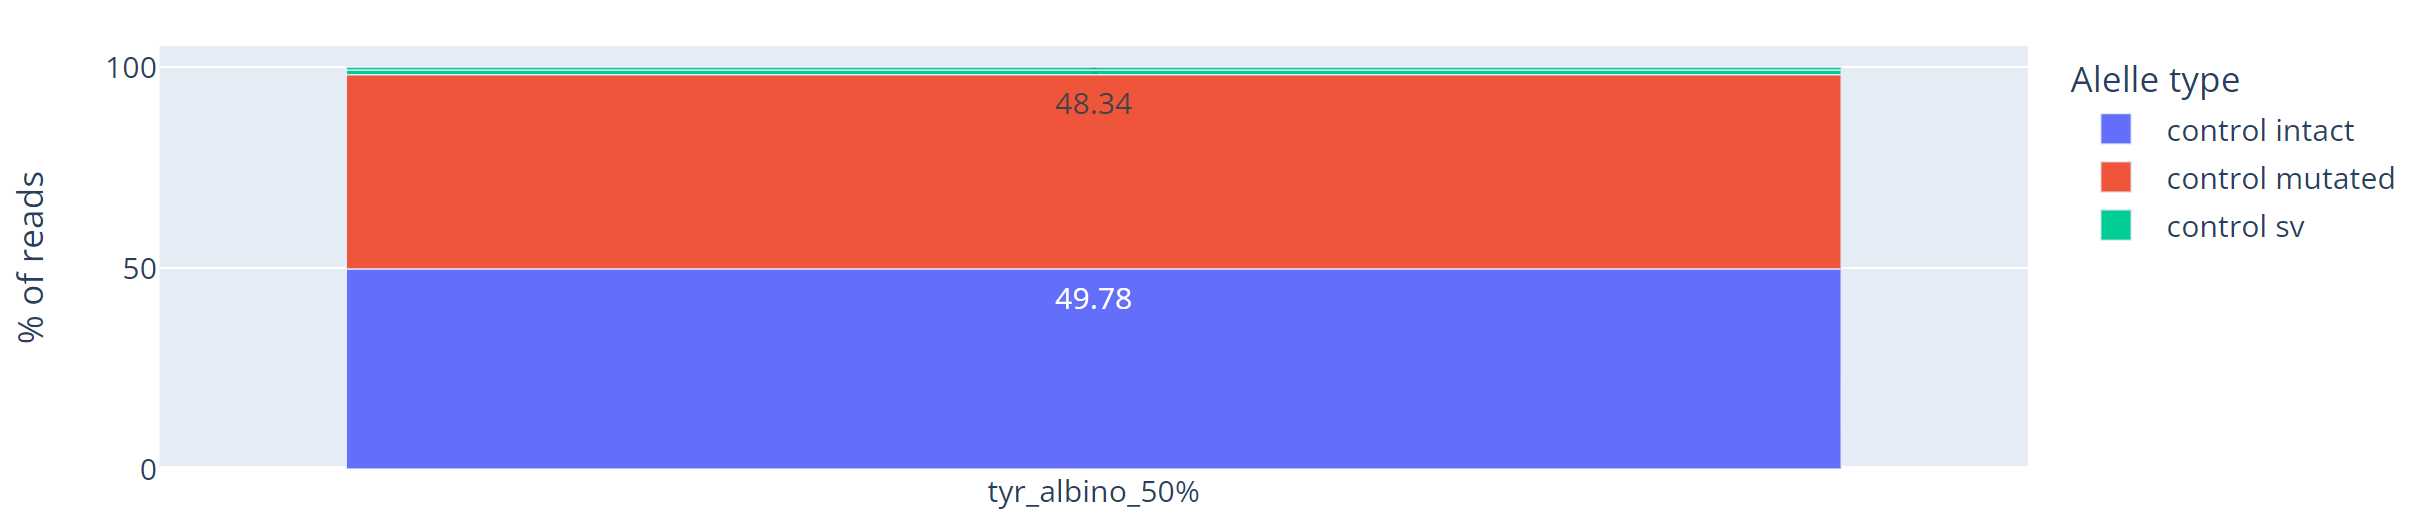

- Batchでも試します

In [5]:
%%bash
rm -rf DAJINResults/batch_tyr_50_10_01 DAJINResults/.tempdir/batch_tyr_50_10_01
time DAJIN2 batch -f misc/data/design_batch_tyr_50_10_01.csv

misc/data/tyr_control.fq.gz is now processing...
misc/data/tyr_albino_50%.fq.gz is now processing...


Classify...
Clustering...
Consensus call...


misc/data/tyr_albino_10%.fq.gz is now processing...


Classify...
Clustering...
Consensus call...


misc/data/tyr_albino_01%.fq.gz is now processing...


Classify...
Clustering...
Consensus call...


Finished! Open DAJINResults/batch_tyr_50_10_01 to see the report.

real	10m25.100s
user	9m51.496s
sys	3m54.852s


- うまくいきました！！！

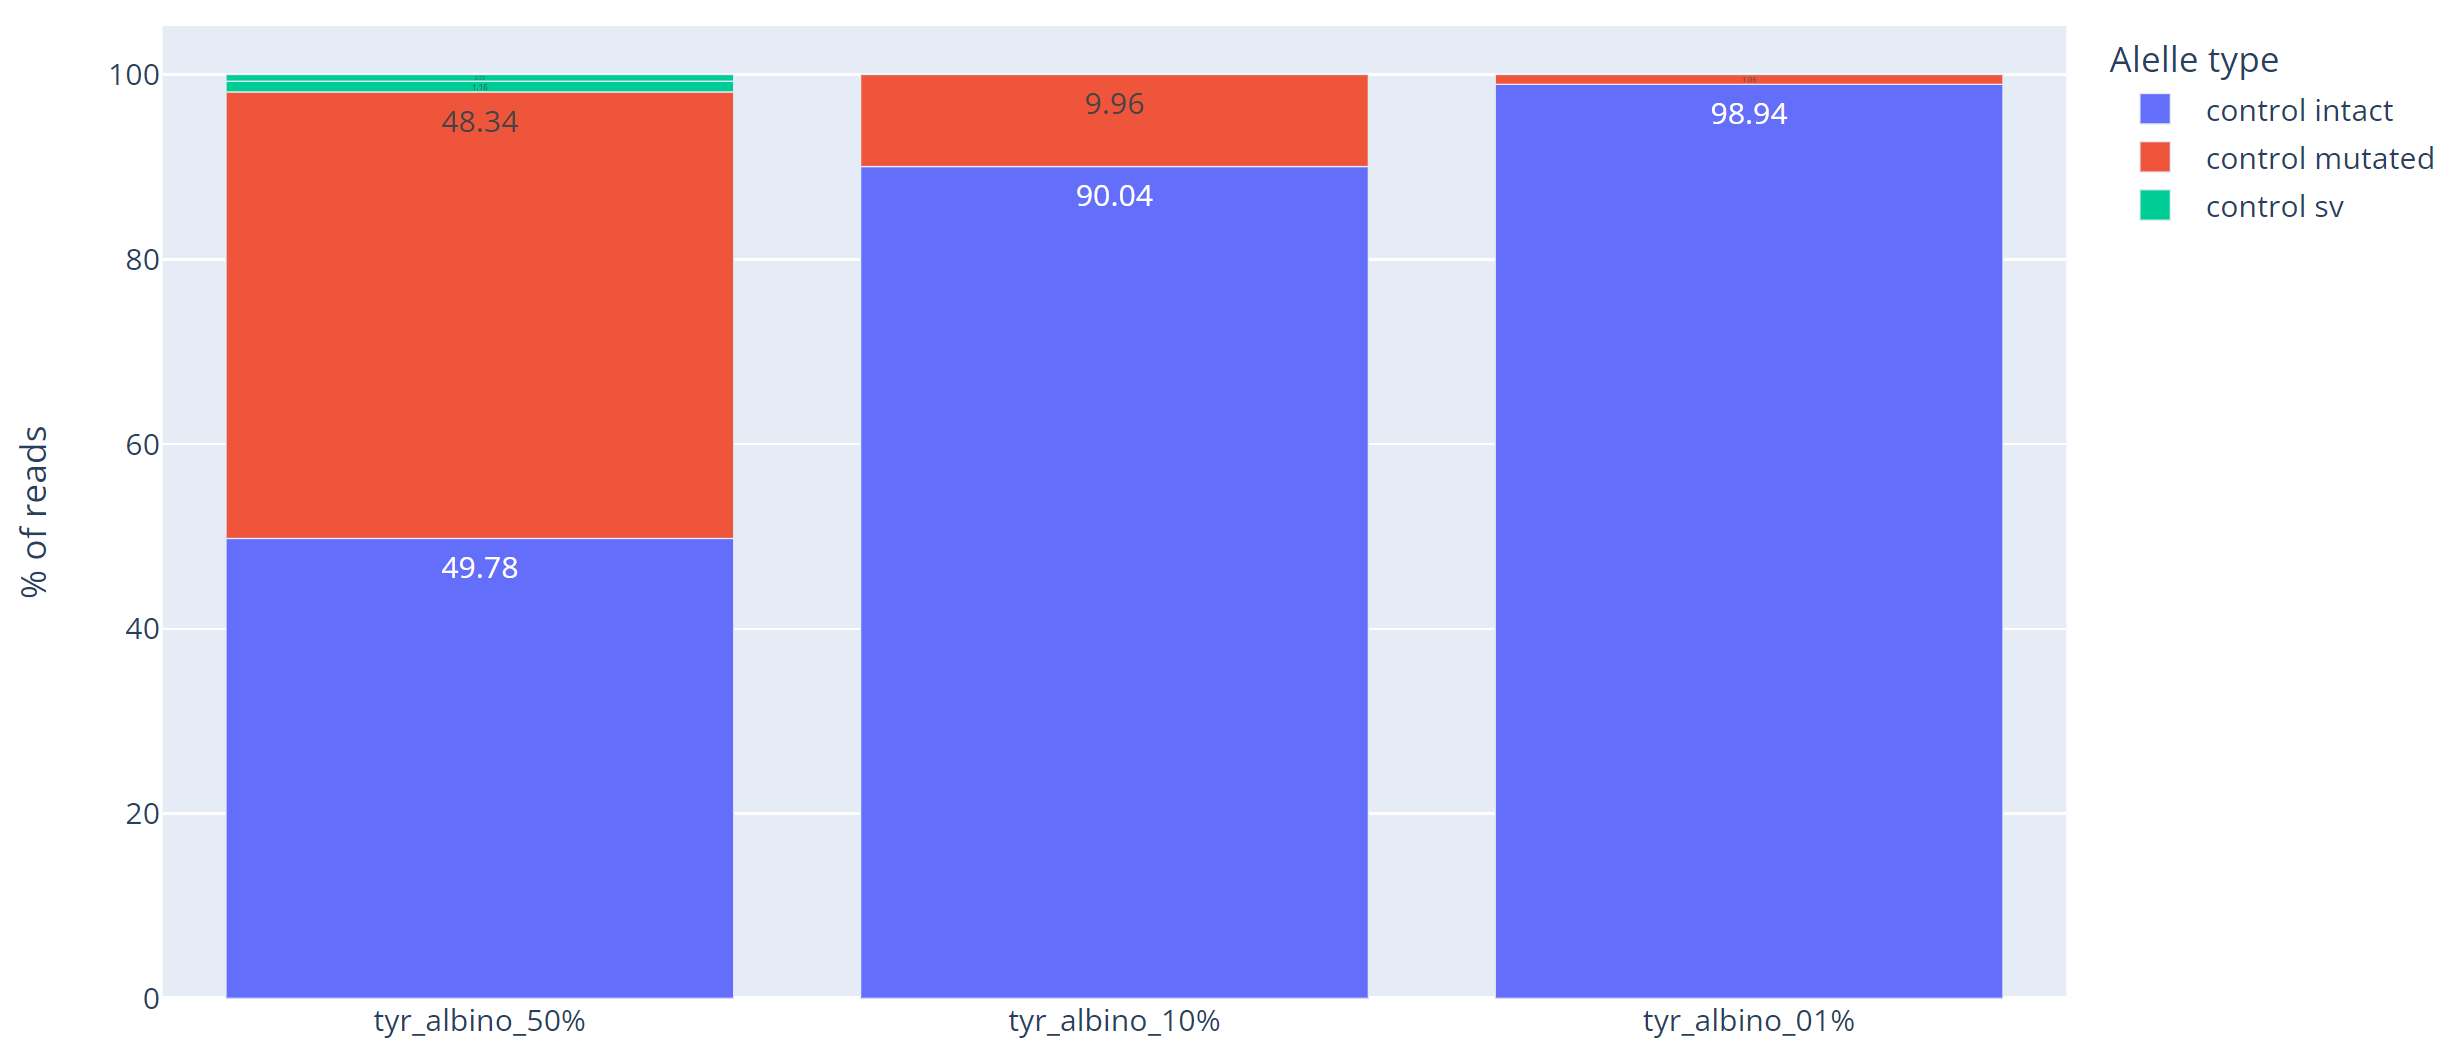

# 👌👌👌 いまここ 👌👌👌

# まとめ


- `tyr_50`でのエラーを解決しました
  - `clustering.annotate_score`に空のディレクトリが入ったときに`score=0`とするように設定しました

- Batchモードできれいに分類することができるようになりました

- 次はSVの判定をコンセンサスのほうに入れます
  - コントロールにも見られる断端リードをなくせることを期待しています

# 次に取り組むこと

### Lists

+ **`SV`の判定をconsensus callのあとにする**

+ [ ] 短いリードの扱いをどうするべきか
+ [ ] cis変異の両端が欠失している場合に、Nで置き換えるとtransとなってしまうのをどうするか（`clustering.replace_both_ends_n`）
+ [ ] Insertionのなかにある変異を同定する手法を考案する
+ [ ] Ayabe-taks1のright_loxpがいまいちな理由を考察する
+ [ ] `preprocess.correct_sequence_error.replace_atmark`のコードがわかりにくい
    + テストを用意してリファクタリングする